In [636]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import option_context

import plotly.express as px

import warnings

warnings.simplefilter("ignore") #suppressing warnings use: warnings.resetwarnings() to reset back to default
#warnings.resetwarnings()

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

from scipy.stats import ttest_ind

import pmdarima as pm

from datahelper import *
import startup_config_preferences
import pickle
import os
import jinja2

from openpyxl.styles import PatternFill, Alignment, Border, Side, Font
from pptx import Presentation
from pptx.enum.shapes import MSO_SHAPE
from pptx.enum.text import MSO_AUTO_SIZE, PP_ALIGN
from pptx.util import Inches, Pt
from pptx.dml.color import RGBColor

# <strong> Classes and Functions </strong>

In [2]:
class GrangerHelper:
    def __init__(self, df, fcol, input_values = None, target_descriptions = None):
        self.df = df.copy()
        self.fcol = fcol
        values = -1*df.Debit if input_values is None else input_values
        
        if not hasattr(self, "max_lag") or not hasattr(self, "time_col"):
            raise NotImplementedError("GrangerHelper is an abstract class, time_col and max_lag must be called from derived classes")
        
        if target_descriptions is None:
            self.df_crosstab = self.get_crosstab(values)
        else:
            self.df_crosstab = self.get_crosstab(values, GrangerHelper.outer_query(df, "Description", target_descriptions, "txn_amt"))

        self.results = GrangerHelper.granger_causality(self.df_crosstab, self.max_lag, self.fcol)

        txn_sums = self.df.groupby(["fyear", "Period"]).txn_amt.sum()
        df_peaks = ((txn_sums > txn_sums.shift(-1))*(txn_sums > txn_sums.shift(1))).rename("peaks").to_frame().join(((txn_sums < txn_sums.shift(-1))*(txn_sums < txn_sums.shift(1))).rename("troughs").to_frame())
        df_trends = ((txn_sums > txn_sums.shift(-1))*(txn_sums < txn_sums.shift(1))).rename("downward").to_frame().join(((txn_sums < txn_sums.shift(-1))*(txn_sums > txn_sums.shift(1))).rename("upward").to_frame())
        self.df_trends = self.df.groupby(["fyear", "Period", "desc1", "Account"]).txn_amt.sum().unstack("Account").join(df_peaks.join(df_trends).idxmax(axis = 1).rename("trends"))
        
    def set_scale (df, col):
        return df.copy().eval(f"{col} = ({col} - {col}.mean())/{col}.std()")

    def get_crosstab(self, value_col = 'txn_amt', target_col = 'txn_amt'):
        times = self.df[self.time_col] if type(self.time_col) == str else self.time_col
        features = self.df[self.fcol] if type(self.fcol) == str else self.fcol
        values = self.df[value_col] if type(value_col) == str else value_col
        targets = self.df[target_col] if type(target_col) == str else target_col

        return self.make_stationary(pd.crosstab(times, 
                            features,
                            values = values, 
                            aggfunc = "sum"
                        )
                    .fillna(0)
                    .join(targets.groupby(times).sum())
                )

    def granger_causality(df_crosstab, max_lag, fcol):
        df_checklag = df_crosstab[df_crosstab.columns[~(df_crosstab.take(range(max_lag, df_crosstab.shape[0]-max_lag)).sum() == 0)]].drop("txn_amt", axis = 1)

        feature_list = []

        for feature in df_checklag.columns.unique():
            #print(feature)
            results = grangercausalitytests(df_crosstab[["txn_amt", feature]], maxlag = max_lag, verbose = 0)
            
            for i in range(1, len(results)+1):
                feature_list.append([feature, i, min([t[1] for t in results[i][0].values()])])

        return pd.DataFrame(feature_list, columns = [fcol, "lag", "pvalue"]).query("pvalue < 0.05").sort_values("pvalue", ascending = False)

    def outer_query(df, query_col, query_target, val_col):
        if type(query_target) == str:
            condition = df[query_col] == query_target
        else:
            condition = df[query_col].apply(lambda x: x in query_target)

        return ((condition).astype(int)*df[val_col]).rename(val_col)
    
    def get_time_col(self):
        return self.time_col
    
    def plot_lags(self, lags = None, xlim = None):
        plt.figure(figsize = (18,10))
        lags_list = []

        if lags is None:
            col_names = self.df_crosstab.columns
            df_all_desc1_lags = pd.concat([self.df_crosstab.shift(i).set_axis(col_names + "_" + str(i), axis = 1) for i in range(1, 6)], axis = 1).fillna(0) #This is exploding the crosstab table to consider all possible lags
            selected_desc1_lag_cols = self.results.apply(lambda x: x.desc1 + '_' + str(x.lag), axis = 1).values.tolist()
            x1 = df_all_desc1_lags[selected_desc1_lag_cols].sum(axis = 1).to_frame(name = "debit_amt").pipe(GrangerHelper.set_scale, "debit_amt")
            lags_list.append(x1)
            plt.plot(x1, label = x1.columns[0])
        else:
            if type(lags) == int:
                lags = [lags]
            
            for lag in lags:
                lag_features = self.results.query(f"lag == {lag}")[self.fcol].unique().tolist()
                x1 = self.df_crosstab[lag_features].sum(axis = 1).rename("txn_amt").shift(lag).to_frame().pipe(GrangerHelper.set_scale, "txn_amt").rename(columns = {"txn_amt": f"debit_amt_lag{lag}"})
                lags_list.append(x1)
                plt.plot(x1, label = x1.columns[0])

        x2 = self.df_crosstab.txn_amt.to_frame().pipe(GrangerHelper.set_scale, "txn_amt").rename(columns = {"txn_amt":"target_txn_amt_total"})
        x3 = self.df.groupby(self.time_col).txn_amt.sum().rename("txn_amt_total").to_frame().pipe(GrangerHelper.set_scale, "txn_amt_total")
        if x2.shape[0] != x3.shape[0] or (x2.values != x3.values).any():
            plt.plot(x2, label = x2.columns[0], alpha = 0.8, linestyle = "dotted")

        stepsize = 2 if x2.shape[0] < 50 else 7
        # print(len(x2.index[::stepsize]))
        # print(len(self.xtick_labels()[::stepsize]))
        plt.plot(x3, label = x3.columns[0], alpha = 0.7, linestyle = "dashed")
        plt.xticks(ticks = x2.index[::stepsize], labels = self.xtick_labels()[::stepsize], rotation = 60)

        if xlim is not None:
            plt.xlim(xlim)

        plt.legend()
        return pd.concat(lags_list + [x2], axis = 1)

    def lag_stats(self, lags = 2, trough_time_idx = 41):

        if type(lags) == int:
            lags = [lags]

        if type(trough_time_idx) == int:
            trough_time_idx = [trough_time_idx]
        
        lag_trough_idx = {}

        for l in lags:
            for t in trough_time_idx:
                if t - l not in lag_trough_idx:
                    lag_trough_idx[t-l] = []
                lag_trough_idx[t-l].append(l)

        lag_features = self.results.query(f"lag in {lags}")[self.fcol].unique().tolist()
        df_lag_features = self.df.query(f"{self.fcol} in {lag_features} and {self.time_col} in {list(lag_trough_idx.keys())}")
        #time_lag_descriptions = df_lag_features.Description.unique()
        agg_func = lambda x: x.count()/df_lag_features.shape[0]

        self.df_lag_features = df_lag_features

        return (df_lag_features
                    .groupby(["desc1", self.time_col])
                    .txn_amt
                    .agg(['sum', ("freq", agg_func), 'mean'])
                    .apply(lambda x: (x.idxmax()[0], x.name, x.max(), x.idxmax()[1]))
                    .T
                    .set_axis(["desc1", "metric", "value", self.time_col], axis = 1)
                    .reset_index(drop = True)
                    .assign(lag = lambda x: x[self.time_col].map(lag_trough_idx))
        )
    
    def plot_desc1_summary(self, desc1):
        #stepsize = 2 if self.df_crosstab.shape[0] < 50 else 7

        self.df.query(f"desc1 == '{desc1}'").pivot_table(columns = self.fcol, index = self.time_col, values = "txn_amt", aggfunc = "sum").plot(figsize = (18,10), linestyle = "dashed", alpha = 0.6)
        plt.plot(self.df.groupby(self.time_col).txn_amt.sum().to_frame(), label = "all", color = "red")#.pipe(GrangerHelper.set_scale, col = "txn_amt"), label = "all")
        plt.plot(self.df.query(f"desc1 == '{desc1}'").groupby(self.time_col).txn_amt.sum().to_frame(), label = desc1, color = "blue")#.pipe(GrangerHelper.set_scale, col = "txn_amt"), label = "001256")
        
        #plt.xticks(ticks = self.df_crosstab.index[1::stepsize], labels = self.xtick_labels()[::stepsize], rotation = 60)
        plt.legend()
    
    def lag_ols(df_results):
        GLDataHelper(df_results, "target_txn_amt_total").run_pipeline(["ols"])["model"].summary()

    def xtick_labels(self):
        raise NotImplementedError
    
    def make_stationary(self, df):
        return df


class PFYGrangerHelper(GrangerHelper):
    time_col = "period_fyear"
    max_lag = 5
    period_month_mapper = [" ", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"]

    def xtick_labels(self):
        return (self.df[["Period", "fyear", "period_fyear"]]
                    .query("period_fyear in @self.df_crosstab.index")
                    .drop_duplicates()
                    .apply(lambda x: self.period_month_mapper[x.Period] + " FY" + str(x.fyear)[-2:] + " (" + str(x.period_fyear) + ")", axis = 1)
                    .tolist()
                )
    
    def make_stationary(self, df):
        return df.diff().dropna()
    
    def lag_stats(self, lag = 1, trough_time_idx = 40):
        agg_func = lambda x: x.count()/df_lag_features.shape[0]

        lag_features = self.results.query(f"lag == {lag}").desc1.tolist()
        query_condition = f"period_fyear == {trough_time_idx} - {lag} or period_fyear == {trough_time_idx} - {lag} - 1"
        min_diff_desc1 = (self.df
                            .query(f"desc1 in {lag_features}")
                            .query(query_condition)
                            .pivot_table(index = "period_fyear", columns = "desc1", values = "txn_amt", aggfunc = "sum")
                            .set_axis(["period1", "period2"])
                            .T
                            .eval("period_diff = period2 - period1")
                            .idxmin()
                            .period_diff
                            )
        df_lag_features = (self.df
                            .query(f"desc1 == '{min_diff_desc1}'")
                            .query(query_condition)
                        )

        return (df_lag_features.groupby("Description")
                    .txn_amt
                    .agg(['sum', ("freq", agg_func), 'mean'])
                    .apply(lambda x: (x.idxmax(), x.name, x.max()))
                    .T
                    .set_axis(["Description", "metric", "value"], axis = 1)
                    .reset_index(drop = True)
                    .eval(f"time_col = '{self.time_col}'")
                    .eval(f"lag = {lag}")
                    .eval(f"trough_time_idx = {trough_time_idx}"),
                    df_lag_features.Description.unique()
                )
        
class WFYGrangerHelper(GrangerHelper):
    time_col = "week_fyear"
    max_lag = 21

    def xtick_labels(self):
        return (self.df[["Date", "week", "fyear", "week_fyear"]]
                    .groupby("week_fyear")
                    .Date
                    .min()
                    .dt
                    .strftime("%m/%d/%y")
                    .reset_index()
                    .apply(lambda x: x.Date + " (" + str(x.week_fyear) + ")", axis = 1)
                    .tolist()
                )
    def get_week_fyears(self, Period, fyear):
        return self.df.query(f"Period == {Period} and fyear == {fyear}").week_fyear.unique()

    def get_period_fyear(self, week_fyear):
        return (self.df.query(f"week_fyear == {week_fyear}").Period.unique()[0],
                self.df.query(f"week_fyear == {week_fyear}").fyear.unique()[0]
                )
    
    def get_period_by_year(self, week_fyear):
        week = self.df.query("week_fyear == @week_fyear").week.unique()[0]
        return self.df.query("week == @week").groupby("fyear").apply(lambda x: x.Period.unique()[0])

    def lag_stats(self, lags = 2, trough_time_idx = 41, trough_idx = None, normalize = False):
        lag_table = super().lag_stats(lags, trough_time_idx)

        lag_table = (lag_table
                .assign(Period = lambda x: x[self.time_col].apply(lambda y: self.get_period_fyear(y)[0]))
                .assign(fyear = lambda x: x[self.time_col].apply(lambda y: self.get_period_fyear(y)[1]))
        )
        desc1_list = lag_table.desc1.tolist()
        week_fyear_list = lag_table.week_fyear.tolist()
    
        display(lag_table)
        
        df_trends = self.df_trends

        if normalize:
            df_trends = (self.df_trends
                            .drop("trends", axis = 1)
                            .groupby(["fyear", "Period"], as_index = False)
                            .apply(lambda df: df.apply(lambda x: x/x.sum()))
                            .reset_index(level = 0, drop = True)
                            .join(self.df_trends.trends)
                        )
        
        desc1_table_dict = {}

        for wfy,desc1 in zip(week_fyear_list, desc1_list):
            period_table = self.get_period_by_year(wfy).reset_index(name = "Period").merge(df_trends.reset_index(), on = ["Period", "fyear"])
            
            if trough_idx is not None:
                period_table = pd.concat([period_table, df_trends.query("Period == @trough_idx").reset_index()], axis = 0).set_index(["Period", "fyear", "desc1"]).unstack("Period")
            
            # desc_dict[(desc1, wfy)] = self.df.query("desc1 == @desc1 and week_fyear == @wfy").sort_values(ascending = False, by = "txn_amt").Description.head(5).tolist()
            desc1_table_dict[(desc1, wfy)] = period_table.query("desc1 == @desc1").dropna(axis = 1, how = "all")
            desc1_table_dict[(desc1, wfy)] = pd.concat([
                                                            desc1_table_dict[(desc1, wfy)].filter(regex = "Acct").fillna(0),
                                                            desc1_table_dict[(desc1, wfy)].filter(regex = "trends").fillna(" -- ")
                                                        ], axis = 1).round(2)
    
            display(
                        (desc1, wfy),
                        desc1_table_dict[(desc1, wfy)]
            )
        
        return lag_table, desc1_table_dict

In [3]:
#PatternFill openpyxl reference for working with styles: https://openpyxl.readthedocs.io/en/stable/styles.html
#Color Picker URL: https://redketchup.io/color-picker

def write_or_append_to_excel(df, filename, sheetname, title):
    if len(sheetname) > 31:
        raise ValueError("Sheetname length must be no more than 31 characters long")
    
    edit_mode_var, if_sheet_exists = ("a", "replace") if os.path.isfile(filename) else ("w", None)
    
    with pd.ExcelWriter(filename, mode = edit_mode_var, if_sheet_exists = if_sheet_exists) as writer:
        df.to_excel(writer, sheet_name = sheetname, startcol = 1, startrow = 1, engine = "openpyxl")

        #workbook = writer.book
        worksheet = writer.sheets[sheetname]

        green_header = PatternFill(start_color='FF70AD47', fill_type = "solid")
        alignment = Alignment(horizontal="center", 
                              vertical = "center",
                              wrap_text = True
                            )
        thick_border_side = Side(border_style="thick", color = "000000")
        thin_border_side = Side(border_style="thin", color = "000000")

        #Defining Input Table Shape Variables
        nrows = df.index.shape[0]
        ncolumns = df.columns.shape[0]

        #Delete Exported Row
        if df.columns.nlevels > 1:
            worksheet.delete_rows(df.columns.nlevels+2)
        #
            
        #Defining Table Variables
        table_row_start = 2
        table_row_end = table_row_start + df.columns.nlevels + nrows - 1
        table_col_start = 2
        table_col_end = table_col_start + ncolumns

        #Defining Table Body Variables
        body_col_start = table_col_start + 1
        body_row_start = table_row_start + df.columns.nlevels

        #Define Iterables
        table_header_iter = [cell for row in worksheet.iter_cols(min_row = table_row_start, max_row = body_row_start-1, min_col = table_col_start, max_col = table_col_end) for cell in row]
        table_idx_iter = [cell for row in worksheet.iter_cols(min_row = table_row_start, max_row = table_row_end, min_col = table_col_start, max_col = table_col_start) for cell in row]
        body_iter = [cell for row in worksheet.iter_cols(min_row = body_row_start, max_row = table_row_end, min_col = body_col_start, max_col = table_col_end) for cell in row]

        #Edit Title
        # worksheet.merge_cells("B1:M1")
        worksheet.merge_cells(start_row = 1, end_row = 1, start_column = table_col_start, end_column = table_col_end)

        worksheet["B1"].value = title
        worksheet["B1"].font = Font(
                                        bold = True,
                                        size = 20
                                    )
        worksheet["B1"].alignment = alignment
        worksheet.row_dimensions[1].height = 50
        

        # Editing Column Headers
        for cell in table_header_iter:
            cell.fill = green_header
            cell.alignment = alignment

            if cell.row == table_row_start:
                if cell.value:
                    #cell.value = cell.value.title()
                    cell.value = " ".join([w[0].upper()+w[1:] for w in cell.value.split()])

                cell.font = Font(
                                    size = 14,
                                    bold = True
                                )
                
            #Add Thick Horizontal Header Border
            if cell.row == body_row_start - 1:
                cell.border =  Border(
                                        top = cell.border.top,
                                        left = cell.border.left,
                                        right = cell.border.right,
                                        bottom = thick_border_side
                                    )
        #

        #Edit Index
        for cell in table_idx_iter:
            cell.fill = green_header
            cell.border = Border(
                                    top = cell.border.top,
                                    left = cell.border.left,
                                    right = thick_border_side,
                                    bottom = cell.border.bottom
                                )
            cell.alignment = alignment
            worksheet.row_dimensions[cell.row].height = 25
        #

        #Edit Table Body: 
        for cell in body_iter:
            if df.dtypes.tolist()[cell.column - body_col_start] == float:
                cell.number_format = "0.00"

            cell.border = Border(
                                    top = cell.border.top,
                                    left = thin_border_side,
                                    right = thin_border_side,
                                    bottom = thin_border_side
                                )
            cell.fill = PatternFill(start_color='FFEBF1E9', fill_type = "solid")
            cell.alignment = alignment

            if cell.row == body_row_start:
                worksheet.column_dimensions[cell.column_letter].width = 14 #width set here is 0.83 larger than what persists in excel

In [630]:
def create_ppt_table(df, slide_title, table_title):

    def get_merge_cells(col_vals):
        df = (pd.Series(col_vals)
                    .apply(lambda x: pd.Series(x, index = ["Account", "Period"]))
                    .reset_index(names = ["Column_index"])
                    .groupby(["Account"])
                    .apply(lambda x: x.Column_index.values)
                )
        return [[k, i] for k, i in df.items()]
    
    def format_header(headers, row_num):
        for title, idx in headers:
            if not isinstance(idx, int):
                if idx.shape[0] > 1 and not table.cell(row_num, idx[0]).is_merge_origin:
                    table.cell(row_num,idx[0]).merge(table.cell(row_num,idx[1]))
                cell_idx = idx[0]
            else:
                cell_idx = idx
            table.cell(row_num,cell_idx).text = " ".join([w[0].upper()+w[1:] for w in title.split()])
            if table.cell(row_num,cell_idx).text_frame.paragraphs[0].runs:
                table.cell(row_num,cell_idx).text_frame.paragraphs[0].runs[0].font.size = Pt(12)
                table.cell(row_num,cell_idx).text_frame.paragraphs[0].runs[0].font.bold = True
                table.cell(row_num,cell_idx).text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
    
    prs = Presentation("data/presentation_tables.pptm")
    nrows, ncols = df.shape
    nrows += df.columns.nlevels + 1
    row_start = df.columns.nlevels + 1
    prs.slide_width = Inches(16*(5/6))
    prs.slide_height = Inches(9*(5/6))
    for s in prs.slides:
        print(s.shapes.title.text if s.shapes.title else None)
        if not s.shapes.title:
            continue
        if s.shapes.title.text == slide_title:
            slide = s
            table = slide.shapes[1].table
            break
    else:
        slide = prs.slides.add_slide(prs.slide_layouts[5])
        slide.shapes.title.text = slide_title
        x, y, cx, cy = Inches(0), Inches(2), Inches(1.5*ncols), Inches(0)
        table = slide.shapes.add_table(nrows, ncols, x, y, cx, cy).table
        table.cell(0,0).merge(table.cell(0,ncols-1))

    #Generate and Format Table Body
    for r, c in np.ndindex(*np.array(df.shape)):
        table.cell(r+row_start,c).text = df.astype(str).values[r][c]
        table.cell(r+row_start,c).text_frame.paragraphs[0].runs[0].font.size = Pt(12)
        table.cell(r+row_start,c).text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

    #Format Column Headers
    if df.columns.nlevels == 1:
        format_header([[col, i] for i, col in enumerate(df.columns)], row_start-1)
    else:
        format_header([[col[1], i] for i, col in enumerate(df.columns)], row_start-1)
        format_header(get_merge_cells(df.columns.values), row_start-2)
    
    #Format Table Cell Dimensions
    for r in range(row_start,nrows):
        table.rows[r].height = Inches(0.25)
    
    #Generate and Format Table Title
    table.cell(0,0).text = table_title
    
    for p in table.cell(0,0).text_frame.paragraphs:
        p.alignment = PP_ALIGN.CENTER

    prs.save("data/presentation_tables.pptm")

In [ ]:
# with option_context("display.max_rows", 10, "display.max_columns", 10):
#     display(dh.df.query("week_fyear == 172"))

In [4]:
def find_important_features (model):
   return pd.DataFrame(np.array([model.feature_names_in_, model.feature_importances_]).T, columns = ["Name", "Importance"]).sort_values(by = "Importance", ascending = False)

In [637]:
def display_in_thousands(x, pos):
    return f"${x/1000:,.0f}"

def display_in_percents(x, pos):
    return f"{x:,.0%}"


def format_transaction_graph(xlabel, ylabel, title, **kwargs):
    ax = plt.gca()

    if "yformatter" in kwargs:
        ax.yaxis.set_major_formatter(kwargs["yformatter"])
    if "xformatter" in kwargs:
        ax.xaxis.set_major_formatter(kwargs["xformatter"])
    if "legend_title" in kwargs:
        plt.legend(title = kwargs["legend_title"])

    ax.set_xlabel(xlabel, labelpad = 15)
    ax.set_ylabel(ylabel, labelpad = 15)
    plt.title(title)

# <strong> Global Variables </strong>

In [5]:
df_sales = pd.read_csv("data/df_sales_public.csv", index_col = 0, parse_dates = [5])
df_sales.desc1 = df_sales.desc1.fillna("NA")
dh = GLDataHelper(df_sales, "txn_amt")

In [6]:
gh_wfy_account = WFYGrangerHelper(dh.df, "Account")

In [7]:
TOP3_DESC1_LIST = ["CB", "EM", "BK"]

In [8]:
TOP3_ACCT_LIST = ["Acct 4", "Acct 5", "Acct 2"]

# <strong> Testing </strong>

## Stationarity

### Period_fyear

In [ ]:
adfuller(dh.df.groupby("period_fyear").txn_amt.sum(), autolag = "AIC", regression = "ct")[1]
#NOTE: transactions accross period_fyears is not stationary (p-value > 0.05)

0.0991463267377749

In [6]:
adfuller(dh.df.groupby("period_fyear").txn_amt.sum().diff().dropna(), autolag = "AIC", regression = "ct")[1]
#NOTE: with d = 1, transactions accross period_fyears are now stationary (p-value < 0.05)

2.5166690851529662e-05

### Week_fyear

In [7]:
adfuller(dh.df.groupby("week_fyear").txn_amt.sum(), autolag = "AIC", regression = "ct")[1]
#NOTE: transactions accross week_fyears is stationary (p-value < 0.05)

6.024825051705332e-06

In [362]:
(pd.Series([adfuller(dh.df.groupby("period_fyear").txn_amt.sum(), autolag = "AIC", regression = "ct")[1],
 adfuller(dh.df.groupby("period_fyear").txn_amt.sum().diff().dropna(), autolag = "AIC", regression = "ct")[1],
 adfuller(dh.df.groupby("week_fyear").txn_amt.sum(), autolag = "AIC", regression = "ct")[1]
], index = ["period (d=0)", "period (d=1)", "week (d=0)"])
    .apply(round, ndigits = 2)
    .reset_index()
    .set_axis(["Time Interval", "P-Values"], axis = 1)
    .pipe(create_ppt_table, "Adfuller Testing", "Stationarity Testing Results")
)

Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s
Two Sample Ttest Accts
MAPE_ARIMA
MAPE_ARIMA_Others
MAPE_Ensemble
MAPE_Ensemble_Others
WFY Granger Results
OLS_results


## Two Sample Ttesting (Top 3 desc1s)

In [240]:
s_top_3_desc1s = dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("all")
s_no_BK = dh.df.query("desc1 in ['CB', 'EM']").groupby("period_fyear").txn_amt.sum().rename("no_BK")
s_no_EM = dh.df.query("desc1 in ['CB', 'BK']").groupby("period_fyear").txn_amt.sum().rename("no_EM")
s_no_CB = dh.df.query("desc1 in ['EM', 'BK']").groupby("period_fyear").txn_amt.sum().rename("no_CB")

df_top_3_desc1s = (dh.df
                        .query("desc1 in @TOP3_DESC1_LIST")
                        .groupby(["period_fyear", "desc1"]).txn_amt.sum()
                        .reset_index()
                        .groupby("desc1").txn_amt.std()
                        .sort_values(ascending = False)
                )

print("ttest")
print('-'*12)
(pd.concat([s_no_EM, s_no_BK, s_no_CB], axis = 1)
        .fillna(0)
        .apply(lambda x: ttest_ind(x, s_top_3_desc1s)[1])
        .round(2)
        .reset_index()
        .set_axis(["Test", "P-Value"], axis = 1)
        .pipe(create_ppt_table, "Two Sample Ttest Desc1s", "Desc1 T-testing")
        # .pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Two Sample Ttest Desc1s", "Desc1 Ttesting")
)

ttest
------------
Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s


## Two Sample Ttesting (Top 3 Accounts)

In [242]:
s_top_3_accts = dh.df.query("Account in @TOP3_ACCT_LIST").groupby("period_fyear").txn_amt.sum().rename("all")
s_no_Acct2 = dh.df.query("Account in ['Acct 4', 'Acct 5']").groupby("period_fyear").txn_amt.sum().rename("no_Acct2")
s_no_Acct5 = dh.df.query("Account in ['Acct 4', 'Acct 2']").groupby("period_fyear").txn_amt.sum().rename("no_Acct5")
s_no_Acct4 = dh.df.query("Account in ['Acct 2', 'Acct 5']").groupby("period_fyear").txn_amt.sum().rename("no_Acct4")

# df_top_3_desc1s = (dh.df
#                         .query("desc1 in @TOP3_DESC1_LIST")
#                         .groupby(["period_fyear", "desc1"]).txn_amt.sum()
#                         .reset_index()
#                         .groupby("desc1").txn_amt.std()
#                         .sort_values(ascending = False)
#                 )

print("ttest")
print('-'*12)
(pd.concat([s_no_Acct2, s_no_Acct5, s_no_Acct4], axis = 1)
        .fillna(0)
        .apply(lambda x: ttest_ind(x, s_top_3_accts)[1])
        .to_frame(name = "p-value")
        .round(2)
        .reset_index()
        .set_axis(["Test", "P-Value"], axis = 1)
        .pipe(create_ppt_table, "Two Sample Ttest Accts", "Account T-testing")
        #.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Two Sample Ttest Accts", "Account Ttesting")
)


ttest
------------
Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s


In [34]:
unique_accts = dh.df.Account.unique()
total_txn_amt = dh.df.groupby("period_fyear").txn_amt.sum()
(dh.df
    .pivot_table(columns = "Account", index = "period_fyear", values = "txn_amt", aggfunc = "sum")
    .apply(lambda x: total_txn_amt - x)
    .add_prefix("no ")
    .fillna(0)
    .apply(lambda x: ttest_ind(x, total_txn_amt)[1])
    .to_frame(name = "p-value")
    .sort_values("p-value", ascending = False)
)

,p-value
Account,
no Acct 1,0.97
no Acct 11,0.95
no Acct 3,0.90
no Acct 9,0.87
no Acct 10,0.79
no Acct 6,0.76
no Acct 8,0.39
no Acct 2,0.04
no Acct 16,0.01


## Volatility

In [162]:
# print_str = "top 10 desc1 standard deviations"
# print(print_str)
# print("-"*len(print_str))
(
    dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby(["period_fyear", "desc1"]).txn_amt.sum().reset_index().groupby("desc1").txn_amt.std().sort_values(ascending = False).mean()/
    dh.df.groupby(["period_fyear", "desc1"]).txn_amt.sum().reset_index().groupby("desc1").txn_amt.std().sort_values(ascending = False).dropna().mean()
)

41.38413572371045

In [159]:
display(dh.df.query("desc1 not in @TOP3_DESC1_LIST").groupby(["period_fyear", "desc1"]).txn_amt.sum().reset_index().groupby("desc1").txn_amt.std().sort_values(ascending = False).dropna().where(lambda x: x > 0).dropna().mean(),
dh.df.query("desc1 not in @TOP3_DESC1_LIST").groupby(["period_fyear", "desc1"]).txn_amt.sum().reset_index().groupby("desc1").txn_amt.std().sort_values(ascending = False).mean()
)


6485.606517466135

6300.303474109959

## Granger Causality Testing

In [ ]:
gh_wfy_account = WFYGrangerHelper(dh.df, "Account")
lag_table, desc1_table_dict = gh_wfy_account.lag_stats(lags = [3,5], trough_time_idx = gh_wfy_account.get_week_fyears(5, 2023), trough_idx = 5, normalize = True)
lag_table.set_index("desc1", inplace = True)
lag_table.rename(columns = {"week_fyear":"Week FY", "fyear": "FY"}, inplace = True)
lag_table.index.set_names(None, inplace = True)
lag_table.value = lag_table.value.astype(float)
desc1_table_dict_CB172 = desc1_table_dict[('CB', 172)].reset_index("desc1", drop = True).rename(columns = {4:"Jan", 5:"Feb"})
desc1_table_dict_CB172.columns.rename(names = [None,None], inplace = True)
desc1_table_dict_CB172.index.set_names("Year", inplace = True)
desc1_table_dict_CB172.reset_index(col_level = 1, inplace = True)

In [517]:
metric_values = [v for v in lag_table.value]
(lag_table
 .reset_index(names = "Desc1")
 .assign(value = [clean_transactions(metric_values[0]), round(metric_values[1], 2), clean_transactions(metric_values[2])])
 .pipe(create_ppt_table, "lag_stats_summary_P5_FY23", "Desc1 Lag Metrics for Feb FY23")
 )

In [635]:
desc1_table_dict_CB172.pipe(create_ppt_table, "lag_stats_CB_172", "Desc1 CB Comparison for Jan and Feb Periods")

Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s
Two Sample Ttest Accts
MAPE_ARIMA
MAPE_ARIMA_Others
MAPE_Ensemble
MAPE_Ensemble_Others
OLS_results
Adfuller Testing
lag_stats_summary_P5_FY23
WFY Granger Results
lag_stats_CB_172


In [809]:
#Pandas dataframe styling reference url: https://medium.com/@romina.elena.mendez/transform-your-pandas-dataframes-styles-colors-and-emojis-bf938d6e98a2
#More exporting references for excel format exports: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Export-to-Excel

desc1_table_dict_CB172.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "lag_stats_CB_172", "Desc1 CB Comparison Table for Periods 4 and 5")
lag_table.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "lag_stats_summary_P5_FY23", "Desc1 Lag Table for Period 5 and FY23")

## Large Repeating Transactions

In [312]:
df_large_txns_crosstab = pd.read_csv("data/df_large_txns_crosstab.csv", index_col = 0)
df_large_txns_crosstab.columns = df_large_txns_crosstab.add_prefix("rl_").columns.str.replace(".", "_")
dh_rl = DataHelper(df_large_txns_crosstab, target = "rl_txn_amt")
(dh_rl.run_pipeline(["ols"])["model"].results_.pvalues
    .to_frame()
    .assign(Transaction_amt = lambda x: x.index.str.replace("rl_", "$"))
    .reset_index(names = "P-Values", drop = True)
    .set_axis(["P-Values", "Transaction Amounts"], axis = 1)
    [["Transaction Amounts", "P-Values"]]
)
# dh_rl.df

,Transaction Amounts,P-Values
0,Intercept,0.00
1,$83359_94,0.06
2,$84049_87,0.16
3,$84193_7,0.12
4,$84324_1,0.16
5,$84603_33,0.95
6,$86289_95,0.73
7,$91054_02,0.51
8,$97602_97,0.17
9,$135659_45,0.12


In [375]:
def clean_transactions(x):
    return f"${float(x):,.00f}" if isinstance(x, float) or x.replace(".", "").isnumeric() else x

df_large_txns_crosstab = pd.read_csv("data/df_large_txns_crosstab.csv", index_col = 0)
initial_cols = df_large_txns_crosstab.columns
col_mapper = {f"col_{i}": clean_transactions(col) for i, col in enumerate(initial_cols)}
df_large_txns_crosstab.columns = col_mapper.keys()
dh_rl = DataHelper(df_large_txns_crosstab, target = "col_0")
(dh_rl.run_pipeline(["ols"])["model"].results_.pvalues
    .rename(index = col_mapper)
    .apply(round, ndigits = 2)
    .reset_index()
    .set_axis(["Transaction Amounts", "P-Values"], axis = 1)
    #.pipe(create_ppt_table, "OLS_results", "Large Transactions Regression Results")
  )

,Transaction Amounts,P-Values
0,Intercept,0.00
1,"$83,360",0.06
2,"$84,050",0.16
3,"$84,194",0.12
4,"$84,324",0.16
5,"$84,603",0.95
6,"$86,290",0.73
7,"$91,054",0.51
8,"$97,603",0.17
9,"$135,659",0.12


In [376]:
x = 83359.99
clean_transactions(x)

'$83,360'

# <strong> Modelling </strong>

## Granger Causality Modelling

### Period_fyear

In [535]:
gh_pfy = PFYGrangerHelper(dh.df, "desc1")

In [ ]:
ols_results_pfy = GLDataHelper(gh_pfy.plot_lags(lags = [1,2,3,4,5]), "target_txn_amt_total").run_pipeline(["ols"])["model"].results_

In [ ]:
rsquared_title = f"Period_fyear lags\nAdj Rsquared: {ols_results_pfy.rsquared_adj.round(3)*100}%"
(pd.concat(
                [ols_results_pfy.params.rename("Coefficients"), ols_results_pfy.pvalues.rename("pvalues")], 
                axis = 1
        )
        .pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "PFY Granger Results", rsquared_title)
)
        

### Week_fyear

In [285]:
gh_wfy = WFYGrangerHelper(dh.df, "desc1")

In [ ]:
ols_results_wfy = GLDataHelper(gh_wfy.plot_lags(lags = range(1,22)), "target_txn_amt_total").run_pipeline(["ols"])["model"].results_

In [598]:
#TODO: Fix Title for this table.
N = 10
rsquared_title = f"Week Lags (R\u00b2 = {ols_results_wfy.rsquared_adj.round(3)*100}%)"
(pd.concat(
                [ols_results_wfy.params.rename("Coefficients"), ols_results_wfy.pvalues.rename("P-Values")], 
                axis = 1
        )
        .head(N)
        .round(2)
        .reset_index(names = ["Variables"])
        .replace({f"debit_amt_lag{i}": f"Lag {i}" for i in range(1,N)})
        .pipe(create_ppt_table, "WFY Granger Results", rsquared_title)
        #.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "WFY Granger Results", rsquared_title)
)

Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s
Two Sample Ttest Accts
MAPE_ARIMA
MAPE_ARIMA_Others
MAPE_Ensemble
MAPE_Ensemble_Others
OLS_results
Adfuller Testing
lag_stats_summary_P5_FY23
lag_stats_CB_172
WFY Granger Results


## ARIMA

### Top 3 Desc1s

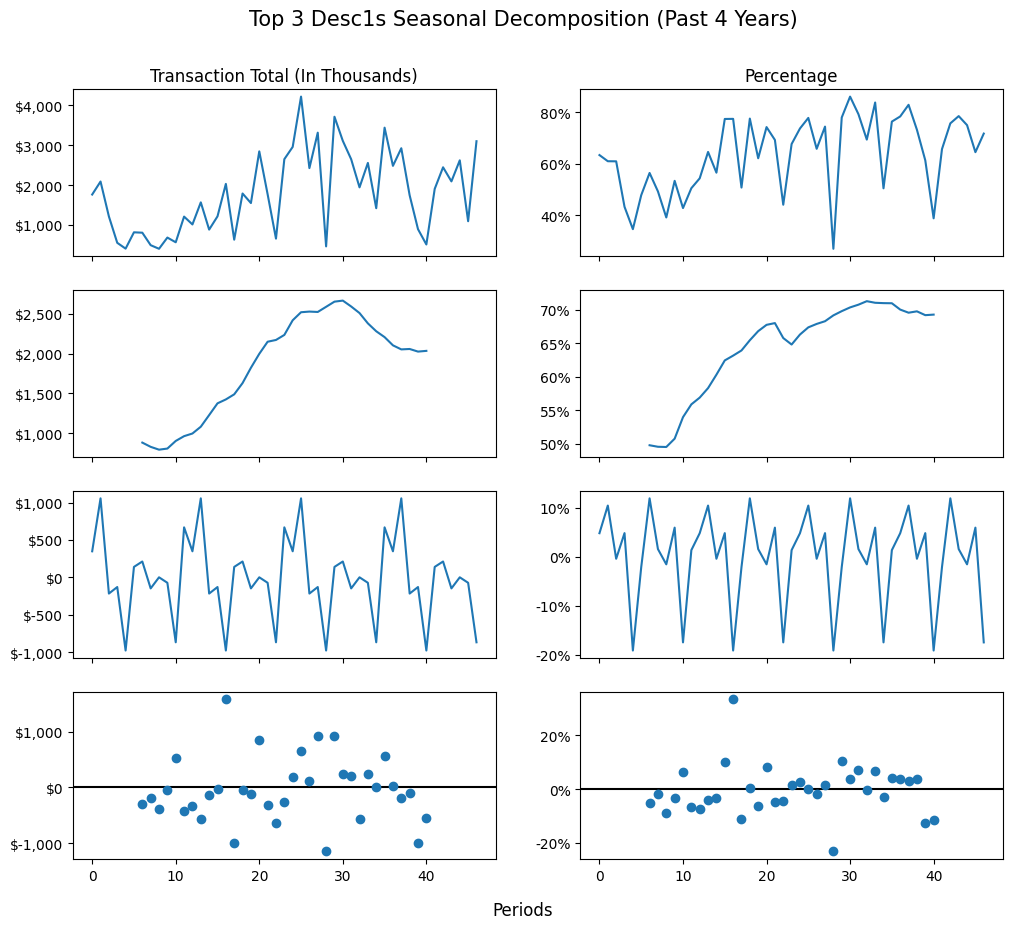

In [678]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, sharex = "col", figsize = (12,10))

total_ts = dh.df.groupby("period_fyear").txn_amt.sum()
def create_pct_txn_ttl_series(df)-> pd.Series:
    s_plot1 = df.groupby("period_fyear").txn_amt.sum().rename("Transaction Total (In Thousands)")
    s_plot2 = (s_plot1/total_ts).rename("Percentage")
    s_plot3 = s_plot1[12:].rename("Transaction Total (In Thousands)")
    s_plot4 = (s_plot1/total_ts)[12:].rename("Percentage")
    return s_plot1, s_plot2, s_plot3, s_plot4

s_plots = create_pct_txn_ttl_series(dh.df.query("desc1 in @TOP3_DESC1_LIST"))
func_list = [display_in_thousands, display_in_percents]
ylim_list = [(.7e6,2.8e6), (.48,.73)]

for col, s in enumerate([s_plots[0], s_plots[1]]):
    seasonal_decomp = seasonal_decompose(s, period = 12)
    axs[0,col].plot(s)
    axs[0,col].set_title(s.name)
    axs[1,col].plot(seasonal_decomp.trend)
    axs[1,col].set_ylim(ylim_list[col])
    axs[2,col].plot(seasonal_decomp.seasonal)
    axs[3,col].axhline(y = 0, color = "black", zorder = 1)
    axs[3,col].scatter(x = seasonal_decomp.resid.index, y = seasonal_decomp.resid, zorder = 2)
    for row in range(4):
        axs[row, col].yaxis.set_major_formatter(func_list[col])
plt.suptitle("Top 3 Desc1s Seasonal Decomposition (Past 4 Years)", size = 15, y = 0.96)
plt.gcf().supxlabel("Periods", y = 0.05)
best_ts = s_plots[3]

Text(0.5, 0.05, 'Periods')

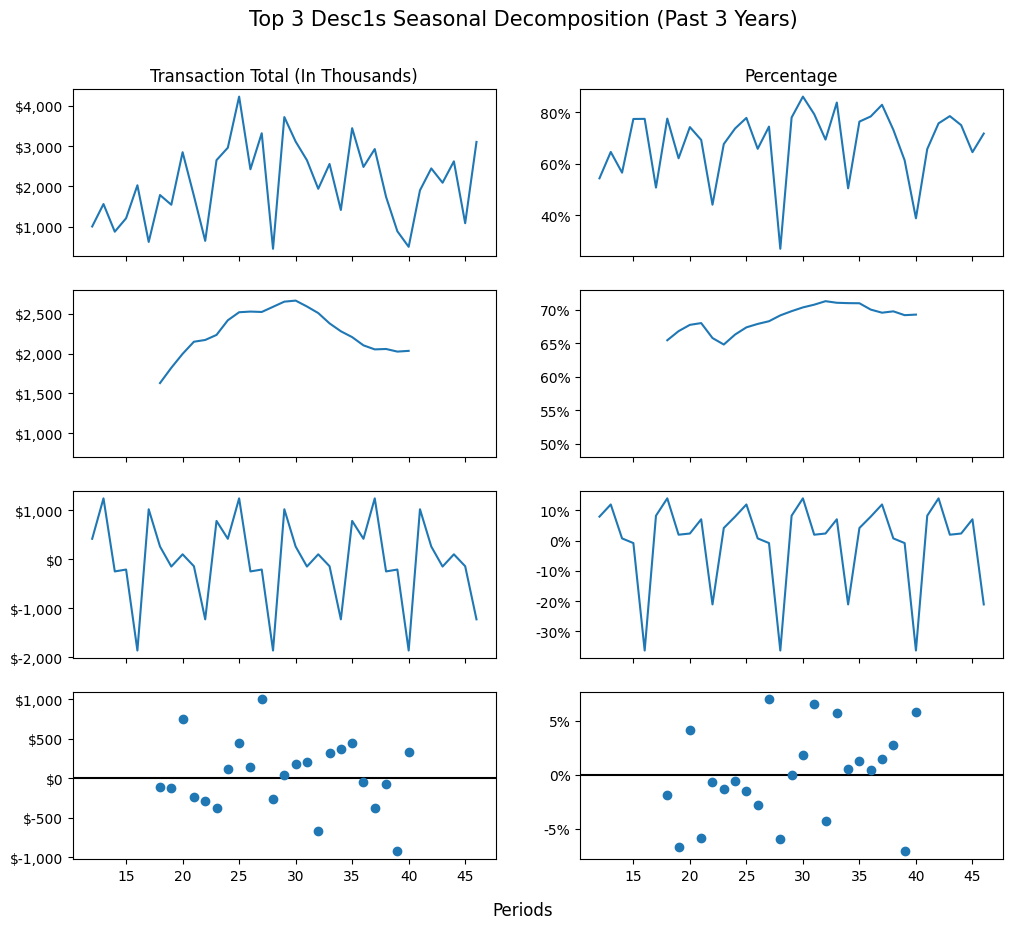

In [679]:
#TODO JUN16: Change Horizontal subplots graph to vertical subplots like seasonal decomp here
fig, axs = plt.subplots(nrows = 4, ncols = 2, sharex = "col", figsize = (12,10))

for col, s in enumerate([s_plots[2], s_plots[3]]):
    seasonal_decomp = seasonal_decompose(s, period = 12)
    axs[0,col].plot(s)
    axs[0,col].set_title(s.name)
    axs[1,col].plot(seasonal_decomp.trend)
    axs[1,col].set_ylim(ylim_list[col])
    axs[2,col].plot(seasonal_decomp.seasonal)
    axs[3,col].axhline(y = 0, color = "black", zorder = 1)
    axs[3,col].scatter(x = seasonal_decomp.resid.index, y = seasonal_decomp.resid, zorder = 2)
    for row in range(4):
        axs[row, col].yaxis.set_major_formatter(func_list[col])
plt.suptitle("Top 3 Desc1s Seasonal Decomposition (Past 3 Years)", size = 15, y = 0.96)
plt.gcf().supxlabel("Periods", y = 0.05)

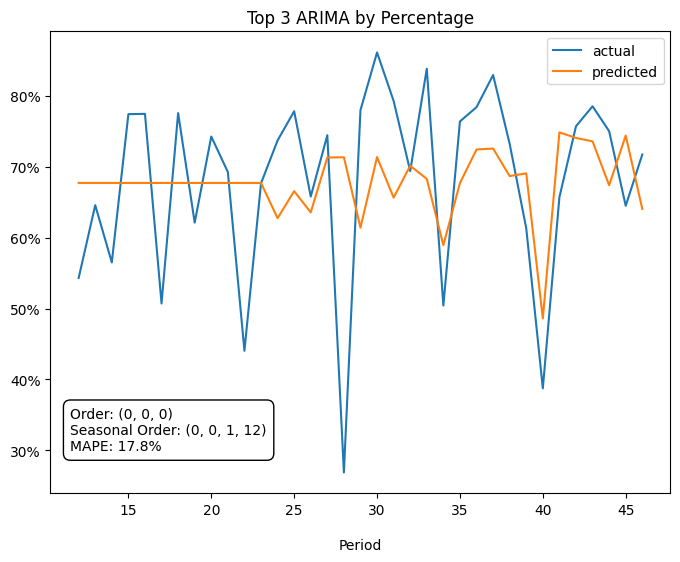

In [643]:
def run_arima(ts, m_freq = 12, plot = False):
    s_model = pm.auto_arima(y = ts, seasonal = True, max_P = 4, max_D = 2, max_Q = 4, test = "adf", m = m_freq, stepwise = True, maxiter = 100)
    pred_ts = pd.Series(s_model.predict_in_sample().values, index = ts.index)
    mape = mean_absolute_percentage_error(y_pred = pred_ts, y_true = ts)
    if plot:
        plt.plot(ts,label = "actual")
        plt.plot(pred_ts, label = "predicted")
        # plt.annotate(f"Order: {s_model.get_params()['order']}\nSeasonal Order: {s_model.get_params()['seasonal_order']}\nMAPE: {round(mape*100, 1)}%", xy = (11.5, 0.3), bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white"))
        plt.legend()
    return s_model, mape

plt.figure(figsize = (8,6))

s_model_best, mape_best = run_arima(best_ts, plot = True)
plt.annotate(
                f"Order: {s_model_best.get_params()['order']}\nSeasonal Order: {s_model_best.get_params()['seasonal_order']}\nMAPE: {round(mape_best*100, 1)}%", 
                xy = (11.5, 0.3), 
                bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white")
            );

format_transaction_graph("Period", "", "Top 3 ARIMA by Percentage", yformatter = display_in_percents)

In [139]:
(dh.df.groupby("desc1").txn_amt.sum().sort_values(ascending = False)/dh.df.txn_amt.sum()).head(3).sum()

0.6798881596034063

In [135]:
dh.df.txn_amt.sum()

122983644.72000001

In [32]:
df_arima_models = pd.concat(s_plots, axis = 1).apply(lambda x: run_arima(x.dropna()))

In [263]:
(df_arima_models
    .set_axis(["model", "MAPE"])
    .T
    .assign(MAPE = lambda x: x.MAPE.apply(round, ndigits = 2))
    .set_index("MAPE", append = True)
    .model
    .apply(lambda x: pd.Series(x.order + x.seasonal_order[:-1], index = ["p", "d", "q", "seasonal P", "seasonal D", "seasonal Q"]))
    .reset_index("MAPE")
    .reset_index(names = "title")
    .assign(Years = lambda x: x.title.str.split().str[1].astype(int))
    .assign(**{"Data Type": lambda x: x.title.str.split("by").str[1]})
    [["Data Type", "Years", 'p', 'd', 'q', "seasonal P", "seasonal D", "seasonal Q", 'MAPE']]
    .pipe(create_ppt_table, "MAPE_ARIMA", "ARIMA Model Results")
    #.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "MAPE_ARIMA", "ARIMA Model Results")
)

Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s
Two Sample Ttest Accts
MAPE_ARIMA


In [261]:
(df_arima_models
    .set_axis(["model", "MAPE"])
    .T
    .assign(MAPE = lambda x: x.MAPE.apply(round, ndigits = 2))

)

,model,MAPE
Past 4 years by Transaction Total,"ARIMA(0,1,2)(0,0,0)[12]",0.26
Past 4 years by Percentage,"ARIMA(1,0,0)(0,0,0)[12] intercept",0.36
Past 3 years by Transaction Total,"ARIMA(2,2,1)(0,0,0)[12]",0.36
Past 3 years by Percentage,"ARIMA(0,0,0)(0,0,1)[12] intercept",0.34


### Other Desc1s

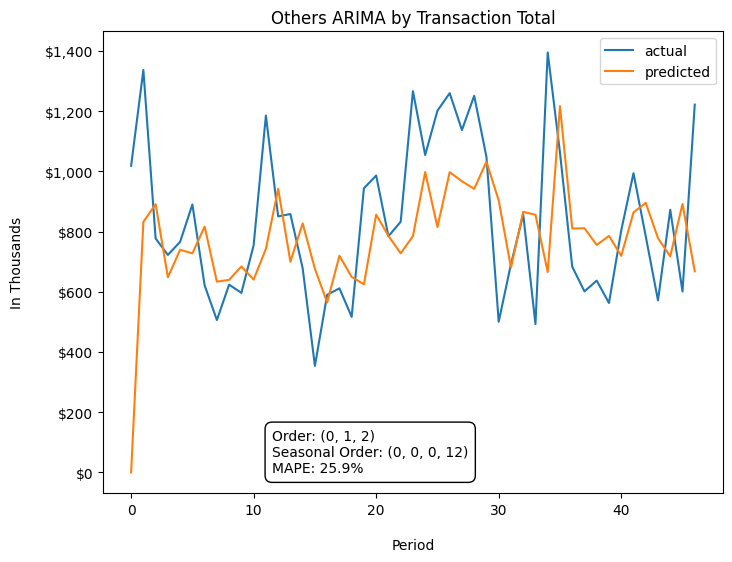

In [649]:
plt.figure(figsize = (8,6))
other_ts = (dh.df.query("desc1 not in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("Top 3 Desc1s Seasonal Decomposition\n(Past 4 years by Transaction)"))
s_model_other, mape_other = run_arima(other_ts, plot = True)
# plt.title("Others ARIMA by Transaction Total")
plt.annotate(
                f"Order: {s_model_other.get_params()['order']}\nSeasonal Order: {s_model_other.get_params()['seasonal_order']}\nMAPE: {round(mape_other*100, 1)}%",
                xy = (11.5, 0.6),
                bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white")
            )
format_transaction_graph("Period", "In Thousands", "Others ARIMA by Transaction Total", yformatter = display_in_thousands)

In [37]:
s_plots_others = create_pct_txn_ttl_series(dh.df.query("desc1 not in @TOP3_DESC1_LIST"))
df_arima_models_others = pd.concat(s_plots_others, axis = 1).apply(lambda x: run_arima(x.dropna()))

In [266]:
(df_arima_models_others
    .set_axis(["model", "MAPE"])
    .T
    .assign(MAPE = lambda x: x.MAPE.apply(round, ndigits = 2))
    .set_index("MAPE", append = True)
    .model
    .apply(lambda x: pd.Series(x.order + x.seasonal_order[:-1], index = ["p", "d", "q", "seasonal P", "seasonal D", "seasonal Q"]))
    .reset_index("MAPE")
    .reset_index(names = "title")
    .assign(Years = lambda x: x.title.str.split().str[1].astype(int))
    .assign(**{"Data Type": lambda x: x.title.str.split("by").str[1]})
    [["Data Type", "Years", 'p', 'd', 'q', "seasonal P", "seasonal D", "seasonal Q", 'MAPE']]
    .pipe(create_ppt_table, "MAPE_ARIMA_Others", "ARIMA Model Results Others")
    #.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "MAPE_ARIMA_Others", "ARIMA Model Results Others")
)

Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s
Two Sample Ttest Accts
MAPE_ARIMA


## Ensemble Modelling

### Random Forest

In [50]:
def gen_top3_matrix(df, pct = False, others = False):
    def helper(x):
        divisor = x.txn_amt.sum() if pct else 1
        query_condition = "desc1 not in @TOP3_DESC1_LIST" if others else "desc1 in @TOP3_DESC1_LIST"
        return x.query(query_condition).txn_amt.sum()/divisor

    return (pd.concat(
                        [df.groupby("period_fyear").apply(helper).shift(-i).rename(f"lag_{i}") for i in range(13)],
                        axis = 1
                    )
                .dropna()
            )

In [41]:
ts_top3_pct_matrix = gen_top3_matrix(dh.df, pct = True)
ts_top3_ttl_matrix = gen_top3_matrix(dh.df)
# X_ts_top3_pct = ts_top3_pct_matrix.drop("lag_12", axis = 1)
# y_ts_top3_pct = ts_top3_pct_matrix.lag_12
# X_ts_top3_ttl, y_ts_top3_ttl = ts_top3_ttl_matrix.drop("lag_12", axis = 1), ts_top3_ttl_matrix.lag_12

In [42]:
params_forest = [{
    "n_estimators": [20, 25, 30, 35, 40],
    "criterion": ['squared_error', 'friedman_mse', 'poisson'],
    "min_samples_leaf": range(2, 8),
    "min_samples_split": np.arange(2,5),
    "random_state": [0]
}]
params_gbr= {
    'n_estimators': [97, 100, 103],
    'learning_rate': [0.016, 0.018, 0.02],
    'max_depth': [3, 4, 5],
    'min_samples_split': [6, 7, 8, 9],
    'min_samples_leaf': [2, 3, 4],
    'subsample': [0.9, 0.92, 0.94],
    'max_features': ['auto', 'sqrt'],
    'random_state' : [0]
}
grid_search_rfr = GridSearchCV(RandomForestRegressor(), params_forest, scoring = 'neg_mean_absolute_percentage_error', cv=3, n_jobs=7, verbose = 3)
grid_search_rfr.fit(X_ts_top3_ttl, y_ts_top3_ttl)

In [43]:
def run_ensemble(df, model):
    X = df.drop("lag_12", axis = 1)
    y = df.lag_12
    model.fit(X, y)
    return model, X, y

def run_ensemble_grid_search(df, model, params):
    df = df.copy()
    X = df.drop("lag_12", axis = 1)
    y = df.lag_12
    grid_search = GridSearchCV(model, params, scoring = 'neg_mean_absolute_percentage_error', cv=3, n_jobs=7, verbose = 3)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_*-1

#### Top 3 Desc1s

In [ ]:
ts_top3_matrix = pd.concat([
                                gen_top3_matrix(dh.df, pct = True).eval("df_type = 'pct'"), 
                                gen_top3_matrix(dh.df, pct = False).eval("df_type = 'ttl'")
                            ])
#ts_top3_matrix = pd.concat([ts_top3_matrix.eval("model_type = 'rfr'"), ts_top3_matrix.eval("model_type = 'gbr'")])
nrows = ts_top3_matrix.shape[0]
ts_top3_matrix = pd.concat([
            ts_top3_matrix.assign(model_type = [RandomForestRegressor]*nrows).assign(params = [params_forest]*nrows).eval("model_name = 'rfr'"), 
            ts_top3_matrix.assign(model_type = [GradientBoostingRegressor]*nrows).assign(params = [params_gbr]*nrows).eval("model_name = 'gbr'")
           ])

grid_search_matrix = ts_top3_matrix.groupby(["df_type", "model_name"]).apply(lambda x: run_ensemble_grid_search(x.filter(regex = "lag"), x.model_type[0](), x.params[0]))

In [278]:
(grid_search_matrix
    .apply(pd.Series)
    .set_axis(["model", "params", "mape_score"], axis = 1)
    .assign(mape_score = lambda x: x.mape_score.apply(round, ndigits = 2))
    .reset_index()[["df_type", "model_name", "mape_score"]]
    .replace({"pct":"Percentage", "ttl":"Transaction Total", "gbr":"Gradient Boosting Regressor", "rfr": "Random Forest Regressor"})
    .rename({"df_type":"Data Type", "model_name":"Model", "mape_score": "MAPE"}, axis = 1)
    .pipe(create_ppt_table, "MAPE_Ensemble", "Ensemble Model Results")
    #.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "MAPE_Ensemble", "Ensemble Model Results")
)

Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s
Two Sample Ttest Accts
MAPE_ARIMA
MAPE_ARIMA_Others


In [274]:
(grid_search_matrix
    .apply(pd.Series)
    .set_axis(["model", "params", "mape_score"], axis = 1)
    .assign(mape_score = lambda x: x.mape_score.apply(round, ndigits = 2))    #.reset_index()[["df_type", "model_name", "mape_score"]]
)

array([[GradientBoostingRegressor(learning_rate=0.018, max_depth=4, max_features='sqrt',
                                  min_samples_leaf=3, min_samples_split=7,
                                  random_state=0, subsample=0.92)                       ,
        {'learning_rate': 0.018, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 0, 'subsample': 0.92},
        0.19],
       [RandomForestRegressor(criterion='poisson', min_samples_leaf=6, n_estimators=30,
                              random_state=0)                                          ,
        {'criterion': 'poisson', 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 30, 'random_state': 0},
        0.19],
       [GradientBoostingRegressor(learning_rate=0.016, max_depth=5, max_features='sqrt',
                                  min_samples_leaf=2, min_samples_split=8,
                                  random_state=0, subsample=0.9)           

In [79]:
grid_search_matrix.apply(pd.Series).set_axis(["model", "params", "mape_score"], axis = 1).query("df_type == 'pct' and model_name == 'gbr'").T.apply(lambda x: run_ensemble(ts_top3_pct_matrix, x.model)).set_axis(["model", "X", "y"])

df_type,pct
model_name,gbr
model,([DecisionTreeRegressor(criterion='friedman_ms...
X,lag_0 lag_1 lag_2 lag_3 lag_...
y,period_fyear 0 0.54 1 0.65 2 0.57 3 ...


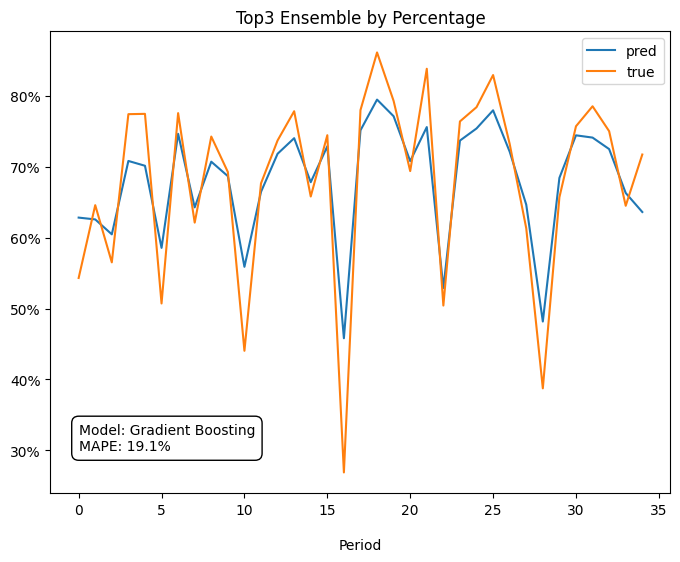

In [647]:
plt.figure(figsize = (8,6))
model_top3, X_top3, y_top3 = run_ensemble(ts_top3_pct_matrix, grid_search_matrix["pct"]["gbr"][0])
plt.plot(model_top3.predict(X_top3), label = "pred")
plt.plot(y_top3, label = "true")
plt.legend()
plt.title("Top3 Ensemble by Percentage")
plt.annotate(
                f"Model: Gradient Boosting\nMAPE: {round(grid_search_matrix['pct']['gbr'][2]*100, 1)}%",
                xy = (0, 0.3),
                bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white")
            );
format_transaction_graph("Period", "", "Top3 Ensemble by Percentage", yformatter = display_in_percents)

In [ ]:
model, X_ensemble, y_ensemble = run_ensemble(
                    ts_top3_pct_matrix, 
                    RandomForestRegressor(
                                            **{'criterion': 'poisson',
                                                'min_samples_leaf': 6,
                                                'min_samples_split': 2,
                                                'n_estimators': 30,
                                                'random_state': 0
                                            }
                                    )
            )
model, X_ensemble, y_ensemble

In [124]:
(abs(grid_search_rfr.best_estimator_.predict(X_top3) - y_top3)/y_top3).mean()

0.1398680018350971

In [179]:
#NOTE: in sample best model for pct, gbr
(abs(grid_search_matrix["pct"]["gbr"][0].predict(X_top3) - y_top3)/y_top3).mean()

0.08234967954082227

In [214]:
#NOTE: in sample best model for pct, rfr
(abs(grid_search_matrix["pct"]["rfr"][0].predict(X_top3) - y_top3)/y_top3).mean()

0.1398680018350971

In [136]:
display(
        grid_search_rfr.best_params_,
        grid_search_rfr.best_score_
    )

#Round 1:
# {'criterion': 'squared_error',
#  'min_samples_leaf': 6,
#  'min_samples_split': 2,
#  'n_estimators': 25,
#  'random_state': 0}

#Round 2:
# {'criterion': 'poisson',
#  'min_samples_leaf': 6,
#  'min_samples_split': 2,
#  'n_estimators': 30,
#  'random_state': 0}

#Best Params:
# {'criterion': 'poisson',
#  'min_samples_leaf': 6,
#  'min_samples_split': 2,
#  'n_estimators': 30,
#  'random_state': 0}

# Best Score: -0.19126906744837444

{'criterion': 'poisson',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 20,
 'random_state': 0}

-0.7396017568811933

#### Other Desc1s

In [ ]:
ts_others_matrix = pd.concat([
                                gen_top3_matrix(dh.df, pct = True, others = True).eval("df_type = 'pct'"), 
                                gen_top3_matrix(dh.df, pct = False, others = True).eval("df_type = 'ttl'")
                            ])

nrows = ts_others_matrix.shape[0]

ts_others_matrix = pd.concat([
            ts_others_matrix.assign(model_type = [RandomForestRegressor]*nrows).assign(params = [params_forest]*nrows).eval("model_name = 'rfr'"), 
            ts_others_matrix.assign(model_type = [GradientBoostingRegressor]*nrows).assign(params = [params_gbr]*nrows).eval("model_name = 'gbr'")
           ])

grid_search_matrix_others = ts_others_matrix.groupby(["df_type", "model_name"]).apply(lambda x: run_ensemble_grid_search(x.filter(regex = "lag"), x.model_type[0](), x.params[0]))

In [282]:
(grid_search_matrix_others
    .apply(pd.Series)
    .set_axis(["model", "params", "mape_score"], axis = 1)
    .assign(mape_score = lambda x: x.mape_score.apply(round, ndigits = 2))
    .reset_index()[["df_type", "model_name", "mape_score"]]
    .replace({"pct":"Percentage", "ttl":"Transaction Total", "gbr":"Gradient Boosting Regressor", "rfr": "Random Forest Regressor"})
    .rename({"df_type":"Data Type", "model_name":"Model", "mape_score": "MAPE"}, axis = 1)
    .pipe(create_ppt_table, "MAPE_Ensemble_Others", "Ensemble Model Results Others")
    #.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "MAPE_Ensemble_Others", "Ensemble Model Results Others")
)

Large_txn_freq
Sample Transformed Data
Time Series Pivot Table
Two Sample Ttest Desc1s
Two Sample Ttest Accts
MAPE_ARIMA
MAPE_ARIMA_Others
MAPE_Ensemble


In [267]:
grid_search_matrix

df_type  model_name
pct      gbr           (([DecisionTreeRegressor(criterion='friedman_m...
         rfr           ((DecisionTreeRegressor(criterion='poisson', m...
ttl      gbr           (([DecisionTreeRegressor(criterion='friedman_m...
         rfr           ((DecisionTreeRegressor(criterion='poisson', m...
dtype: object

In [91]:
gen_top3_matrix(dh.df, pct = False, others = True)

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
period_fyear,,,,,,,,,,,,,
0,"1,018,839.58","1,337,262.10","777,264.50","722,752.21","766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95"
1,"1,337,262.10","777,264.50","722,752.21","766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95","858,530.96"
2,"777,264.50","722,752.21","766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95","858,530.96","678,698.43"
3,"722,752.21","766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95","858,530.96","678,698.43","354,118.98"
4,"766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95","858,530.96","678,698.43","354,118.98","590,364.39"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,"500,650.96","691,905.66","856,978.36","492,939.03","1,395,436.38","1,062,928.00","683,514.73","601,437.33","637,389.90","563,030.77","803,918.41","994,348.01","784,519.55"
31,"691,905.66","856,978.36","492,939.03","1,395,436.38","1,062,928.00","683,514.73","601,437.33","637,389.90","563,030.77","803,918.41","994,348.01","784,519.55","571,750.61"
32,"856,978.36","492,939.03","1,395,436.38","1,062,928.00","683,514.73","601,437.33","637,389.90","563,030.77","803,918.41","994,348.01","784,519.55","571,750.61","872,638.87"


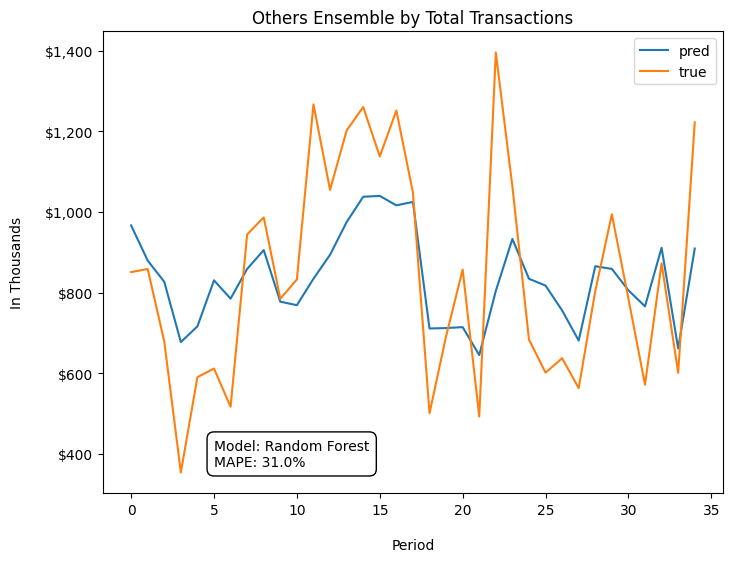

In [650]:
plt.figure(figsize = (8,6))
model, params, mape = grid_search_matrix_others["ttl"]['rfr']
model_others, X_others, y_others = run_ensemble(
                                        gen_top3_matrix(dh.df, pct = False, others = True), 
                                        model
                                       )
plt.plot(model_others.predict(X_others), label = "pred")
plt.plot(y_others, label = "true")
plt.legend()
plt.title("Others Ensemble by Total Transactions")
plt.annotate(
                f"Model: Random Forest\nMAPE: {round(mape*100, 1)}%",
                xy = (5, 0.37e6),
                bbox = dict(boxstyle = "round, pad = 0.5", facecolor = "white")
            );
format_transaction_graph("Period", "In Thousands", "Others Ensemble by Total Transactions", yformatter = display_in_thousands)

In [218]:
X_others

,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
period_fyear,,,,,,,,,,,,
0,"1,018,839.58","1,337,262.10","777,264.50","722,752.21","766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33"
1,"1,337,262.10","777,264.50","722,752.21","766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95"
2,"777,264.50","722,752.21","766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95","858,530.96"
3,"722,752.21","766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95","858,530.96","678,698.43"
4,"766,113.19","890,376.20","621,560.73","506,290.72","624,057.15","596,564.51","754,821.54","1,185,715.33","850,800.95","858,530.96","678,698.43","354,118.98"
...,...,...,...,...,...,...,...,...,...,...,...,...
30,"500,650.96","691,905.66","856,978.36","492,939.03","1,395,436.38","1,062,928.00","683,514.73","601,437.33","637,389.90","563,030.77","803,918.41","994,348.01"
31,"691,905.66","856,978.36","492,939.03","1,395,436.38","1,062,928.00","683,514.73","601,437.33","637,389.90","563,030.77","803,918.41","994,348.01","784,519.55"
32,"856,978.36","492,939.03","1,395,436.38","1,062,928.00","683,514.73","601,437.33","637,389.90","563,030.77","803,918.41","994,348.01","784,519.55","571,750.61"


In [220]:
y_others

period_fyear
0      850,800.95
1      858,530.96
2      678,698.43
3      354,118.98
4      590,364.39
         ...     
30     784,519.55
31     571,750.61
32     872,638.87
33     601,215.49
34   1,222,124.25
Name: lag_12, Length: 35, dtype: float64

In [221]:
#NOTE: in sample best model for ttl, rfr (Others desc1s)
(abs(grid_search_matrix_others["ttl"]["rfr"][0].predict(X_others) - y_others)/y_others).mean()

0.20630101237747867

### Gradient Boosting

In [ ]:
params_gbr= {
    'n_estimators': [97, 100, 103],
    'learning_rate': [0.016, 0.018, 0.02],
    'max_depth': [3, 4, 5],
    'min_samples_split': [6, 7, 8, 9],
    'min_samples_leaf': [2, 3, 4],
    'subsample': [0.9, 0.92, 0.94],
    'max_features': ['auto', 'sqrt'],
    'random_state' : [0]
}
grid_search_gbr = GridSearchCV(GradientBoostingRegressor(), params_gbr, scoring = 'neg_mean_absolute_percentage_error', cv=3, n_jobs=7, verbose = 3)
grid_search_gbr.fit(X_ts_top3, y_ts_top3)

In [ ]:
display(
        grid_search_gbr.best_params_,
        grid_search_gbr.best_score_
)
#Round1:
# {'learning_rate': 0.02,
#  'max_depth': 3,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 2,
#  'min_samples_split': 5,
#  'n_estimators': 100,
#  'random_state': 0,
#  'subsample': 0.95}

#Score:-0.193423107073553

#Round2:
# {'learning_rate': 0.02,
#  'max_depth': 4,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 3,
#  'min_samples_split': 7,
#  'n_estimators': 100,
#  'random_state': 0,
#  'subsample': 0.95}

#Score:-0.19095948061531262

#Round3:
# {'learning_rate': 0.018,
#  'max_depth': 4,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 3,
#  'min_samples_split': 7,
#  'n_estimators': 100,
#  'random_state': 0,
#  'subsample': 0.92}

# Score: -0.19077766275287114

#Best Params:
# {'learning_rate': 0.018,
#  'max_depth': 4,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 3,
#  'min_samples_split': 7,
#  'n_estimators': 100,
#  'random_state': 0,
#  'subsample': 0.92}

# Best Score: -0.19077766275287114